# Supplemental Figures

## Setup

### imports

In [64]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, zscore
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from tqdm import tqdm

from dms_3d_features.plotting import *
from tabulate import tabulate
import re
import os


from rna_motif_library.dataframe_tools import (  # pyright: ignore[reportMissingImports]
    add_motif_indentifier_columns,
)

## load data

In [65]:
DATA_PATH = "../../data"
REVISION_PATH = "../../data/revisions"

In [ ]:
df_construct = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df_construct_2 = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_2.json")
df_contruct_nomod = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_nomod.json"
)
df_motif = pd.read_json(
    f"{DATA_PATH}/raw-jsons/motifs/pdb_library_1_motifs_standard.json"
)
df1 = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df = df1.query("r_type != 'Flank-WC'").copy()
df_avg = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_avg.json")
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
# generate natural log of DMS
with np.errstate(divide="ignore"):
    df1["ln_r_data"] = np.log(df1["r_data"])
df1["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
# remove outliers
df = df.query("r_data_outlier == False").copy()

df_bp_details = pd.read_csv(f"{DATA_PATH}/csvs/wc_details.csv")
df_bp_details = df_bp_details.query("flanking_pairs == 'YES'")
df_bp_details["ln_r_data"] = np.log(df_bp_details["r_data"])
df_bp_details["ln_r_data"].replace(-np.inf, -9.8, inplace=True)

df_pdb = df_pdb.query("r_data_outlier == False").copy()
df_sasa = pd.read_csv(f"{DATA_PATH}/pdb-features/sasa.csv")
df_sasa["m_sequence"] = df_sasa["m_sequence"].apply(lambda x: x.replace("&", "_"))

# merge and remove extra pdb res
df_sasa_merge = pd.merge(
    df_pdb, df_sasa, on=["m_sequence", "r_nuc", "pdb_r_pos", "pdb_path"]
)
df_sasa_merge = df_sasa_merge.query("not ln_r_data.isnull()")

df_dist = pd.read_csv(f"{DATA_PATH}/pdb-features/non_canonical_atom_distances.csv")
df_ratio = pd.read_csv(
    f"{DATA_PATH}/pdb-features/non_canonical_atom_distances_with_ratio.csv"
)

df_wc = df1.query("r_type == 'Flank-WC'").copy()

df_wc.sort_values("ln_r_data", inplace=True, ascending=False)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [67]:
# Filter rows where pdb_path is an empty list
df_no_pdb = df1.query("has_pdbs == False").copy()

# Remove rows where m_token contains 'HELIX'
df_no_pdb = df_no_pdb[~df_no_pdb["m_token"].str.contains("HELIX", na=False)]

# Get unique values of m_sequence
unique_m_sequences = df_no_pdb["m_sequence"].unique()
print("Number of unique m_sequences (after removing HELIX):", len(unique_m_sequences))

# Get unique values of m_token
unique_m_tokens = df_no_pdb["m_token"].unique()
print("Unique m_tokens (after removing HELIX):", unique_m_tokens)

Number of unique m_sequences (after removing HELIX): 536
Unique m_tokens (after removing HELIX): ['1x1' '2x2']


## Extra functions

In [69]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

In [70]:
def generate_replicate_df(df_construct: pd.DataFrame, df_construct_2) -> pd.DataFrame:
    """
    Generates a replicate DataFrame by merging two input DataFrames based on the 'name' column.

    Args:
        df_construct (pandas.DataFrame): The first DataFrame containing the 'name' and 'data' columns.
        df_construct_2 (pandas.DataFrame): The second DataFrame containing the 'name' and 'data' columns.

    Returns:
        pandas.DataFrame: A new DataFrame with columns 'data_1' and 'data_2', where
            each row contains a pair of corresponding data values from the input DataFrames.

    Raises:
        None
    """
    df_2_sub = df_construct_2[["name", "data"]].copy()
    df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
    df_merge = df_construct.merge(df_2_sub, on="name").copy()
    data = []
    for i, row in df_merge.iterrows():
        for d1, d2 in zip(row["data"], row["data_2"]):
            data.append({"data_1": d1, "data_2": d2})
    df_data = pd.DataFrame(data)
    return df_data

In [72]:
def calculate_sasa_percentages(df_non_wc_pair, sasa_thresholds=[2]):
    results = []
    for threshold in sasa_thresholds:
        below_threshold = (
            df_non_wc_pair[df_non_wc_pair["sasa_0_5"] < threshold].groupby("cat").size()
        )
        total = df_non_wc_pair.groupby("cat").size()
        percentage = (below_threshold / total * 100).round(2)

        results.append(percentage.rename(f"Percent_below_{threshold}"))

    result_df = pd.concat(results, axis=1).fillna(0)
    result_df["Count"] = df_non_wc_pair.groupby("cat").size()

    headers = ["Category"] + list(result_df.columns)
    table_data = [[index] + row.tolist() for index, row in result_df.iterrows()]

    return tabulate(table_data, headers=headers, tablefmt="pipe", floatfmt=".2f")

# Plotting

## Suppplemental Table 3: Residues under 2 A for SASA

In [ ]:
df_non_wc_pair = df_sasa_merge.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != ''and m_token == '1x1'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)

print(calculate_sasa_percentages(df_non_wc_pair))

| Category   |   Percent_below_2 |   Count |
|:-----------|------------------:|--------:|
| A in A-A   |             23.29 |  992.00 |
| A in A-C   |             62.43 |  668.00 |
| A in A-G   |             69.25 |  374.00 |
| C in C-A   |             51.66 |  664.00 |
| C in C-C   |             12.06 |  506.00 |
| C in C-U   |              0.00 |  521.00 |


## Supplemental Figure XXX: Correlation between DMS reactivity and nomod

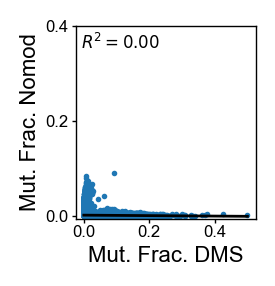

In [ ]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
df_data = generate_replicate_df(df_construct, df_contruct_nomod)
plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], ax=ax)
ax.set_xlabel("Mut. Frac. DMS", labelpad=2)
ax.set_ylabel("Mut. Frac. Nomod", labelpad=2)
ax.set_xticks([0.00, 0.20, 0.40])
ax.set_yticks([0.00, 0.20, 0.40])
format_small_plot(ax)